In [1]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
%cd ../..
%pwd

c:\Users\Suyeon\Desktop\github\menppo


'c:\\Users\\Suyeon\\Desktop\\github\\menppo'

In [3]:
actions = [
    'easy',
    'difficult'
]

data = np.concatenate([
    np.load('dataset/seq_easy_1631650324.npy'),
    np.load('dataset/seq_difficult_1631650324.npy')
], axis=0)

data.shape

(1054, 30, 1887)

In [4]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(1054, 30, 1886)
(1054,)


In [5]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(1054, 2)

In [6]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=42)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(948, 30, 1886) (948, 2)
(106, 30, 1886) (106, 2)


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                499456    
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 501,602
Trainable params: 501,602
Non-trainable params: 0
_________________________________________________________________


In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=80,
    callbacks=[
        ModelCheckpoint('models/eyebrow_model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/80
30/30 [==============================] - 2s 56ms/step - loss: 15.4242 - acc: 0.5253 - val_loss: 5.0709 - val_acc: 0.5377

Epoch 00001: val_acc improved from -inf to 0.53774, saving model to models\eyebrow_model.h5
Epoch 2/80
30/30 [==============================] - 2s 51ms/step - loss: 4.2809 - acc: 0.4916 - val_loss: 3.4006 - val_acc: 0.5472

Epoch 00002: val_acc improved from 0.53774 to 0.54717, saving model to models\eyebrow_model.h5
Epoch 3/80
30/30 [==============================] - 1s 47ms/step - loss: 7.1773 - acc: 0.5116 - val_loss: 9.4714 - val_acc: 0.4528

Epoch 00003: val_acc did not improve from 0.54717
Epoch 4/80
30/30 [==============================] - 1s 45ms/step - loss: 15.4682 - acc: 0.5264 - val_loss: 30.1453 - val_acc: 0.3113

Epoch 00004: val_acc did not improve from 0.54717
Epoch 5/80
30/30 [==============================] - 1s 45ms/step - loss: 13.8827 - acc: 0.4388 - val_loss: 12.3686 - val_acc: 0.4623

Epoch 00005: val_acc did not improve from 0.5471

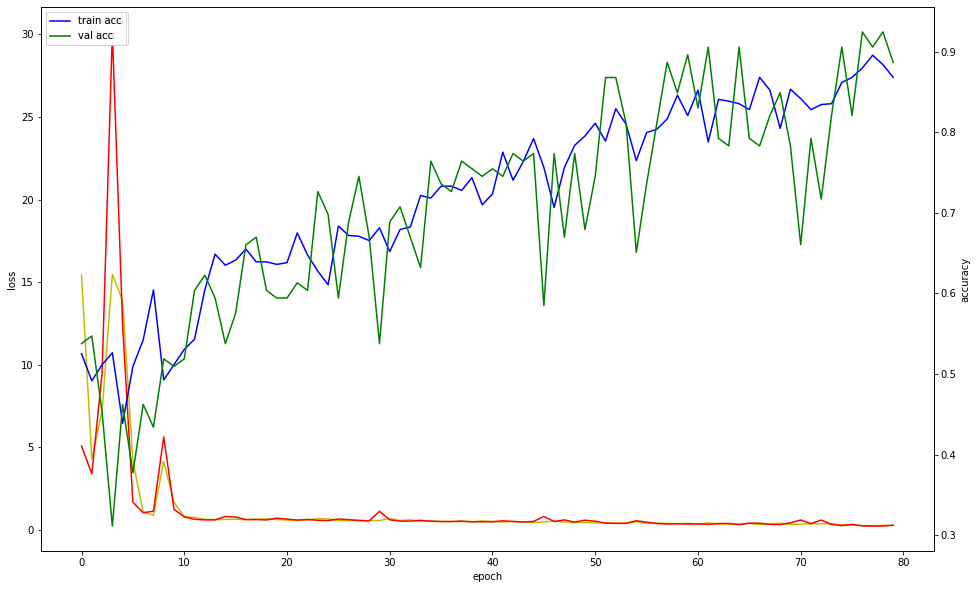

In [9]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [10]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/eyebrow_model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

array([[[49,  6],
        [ 2, 49]],

       [[49,  2],
        [ 6, 49]]], dtype=int64)

## TFlite Model Convert

In [11]:
import tensorflow as tf
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('models/eyebrow_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Suyeon\AppData\Local\Temp\tmpqe8ler6d\assets
